In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pyvisa
import nidaqmx
from nidaqmx.constants import AcquisitionType, TaskMode
import time
import pprint
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [3]:
def save_data(
        main_data,
        fname,
        run_name,
        offset,
        overwrite = True
):
        with h5py.File(fname, "a") as f:
                if run_name in f.keys():
                        if overwrite:
                                del f[run_name]
                try:
                        dset = f.create_dataset(run_name, data=main_data)
                except TypeError:
                        print("Error saving data!")
                        return main_data
                dset.attrs['offset'] = offset

In [32]:
Vpick = []
samp_time = 5
sample_rate = 5000
n_samples = sample_rate * samp_time
Vin = np.zeros(n_samples)
Vpick = np.zeros(n_samples)
tqdm_on = True
tqdm_sq = tqdm if tqdm_on else lambda x: x
value = 4
with nidaqmx.Task() as trig_task, nidaqmx.Task() as master_task, nidaqmx.Task() as slave_task:
    trig_task.ao_channels.add_ao_voltage_chan('Dev1/ao0','trig_channel',0,5)
    master_task.ai_channels.add_ai_voltage_chan("Dev1/ai0:1",'data_channel',max_val=0.2, min_val=-0.2)
    master_task.timing.cfg_samp_clk_timing(sample_rate, samps_per_chan=n_samples)
    for i in tqdm_sq(range(int(np.ceil(n_samples / sample_rate)))):
        i0, i1 = i * sample_rate, i * sample_rate + min(sample_rate, n_samples - i * sample_rate)
        data = master_task.read(number_of_samples_per_channel=sample_rate)
        Vin[i0:i1] = data[1]
        Vpick[i0:i1] = data[0]
        trig_task.write(value)
    trig_task.write(0)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


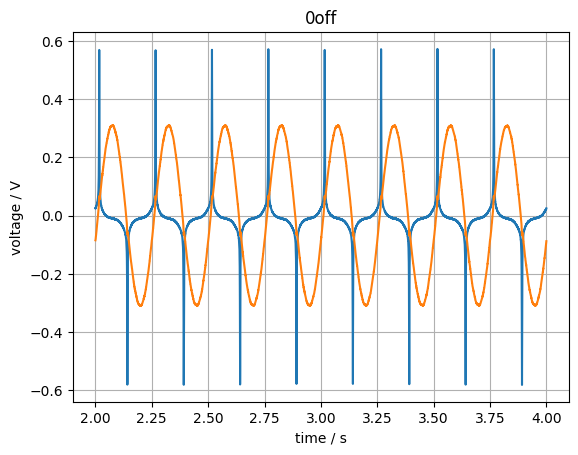

In [33]:
m = np.s_[10000:20000]
time_stamp = np.linspace(0,samp_time,len(Vin))
plt.title("0off")
plt.plot(time_stamp[m],Vpick[m])
plt.plot(time_stamp[m],Vin[m])
plt.xlabel("time / s")
plt.ylabel("voltage / V")
plt.grid(True)

In [34]:
file_name = "C:\\Users\\CeNTREX\\Documents\\GitHub\\new_cavity\\minorloop_4_10_2024.hdf"
run_name = "10Vpp"
offset = 0
data_saved = [Vin,Vpick]
save_data(data_saved,file_name,run_name,offset,overwrite=True)